In [1]:
from fastai.vision import *

In [2]:
from pathlib import Path
import pandas as pd

DATA_ROOT = Path('./covid-chestxray-dataset')
DATA_IMAGES = DATA_ROOT / 'images'

df = pd.read_csv(DATA_ROOT / 'metadata.csv')

# drop useless cols
drop_cols = [
    'needed_supplemental_O2',
    'extubated',
    'temperature',
    'pO2_saturation',
    'leukocyte_count',
    'neutrophil_count',
    'lymphocyte_count'
]
df.drop(drop_cols, axis=1, inplace=True)

# we need only these cols
cols = [
    'patientid',
    'sex',
    'age',
    'finding',
    'folder',
    'filename',
]
df = df[cols]

# also drop all NaN values
df.dropna(inplace=True)


class ALIGN:
    FRONT = 'front'
    TOP = 'top'
    SIDE = 'side'

df['alignment'] = ALIGN.FRONT
df['path'] = df['folder'] + '/' + df['filename']
df['covid19'] = df['finding'] == 'COVID-19'

In [3]:
df = df[df['folder'] == 'images']
recompute_scale_factor=True

In [4]:
BATCH_SIZE = 16
dataBunch = ImageDataBunch.from_df(
    DATA_ROOT,
    df,
    fn_col='path',
    label_col='covid19',
    size=224,
    bs=BATCH_SIZE
).normalize(imagenet_stats)

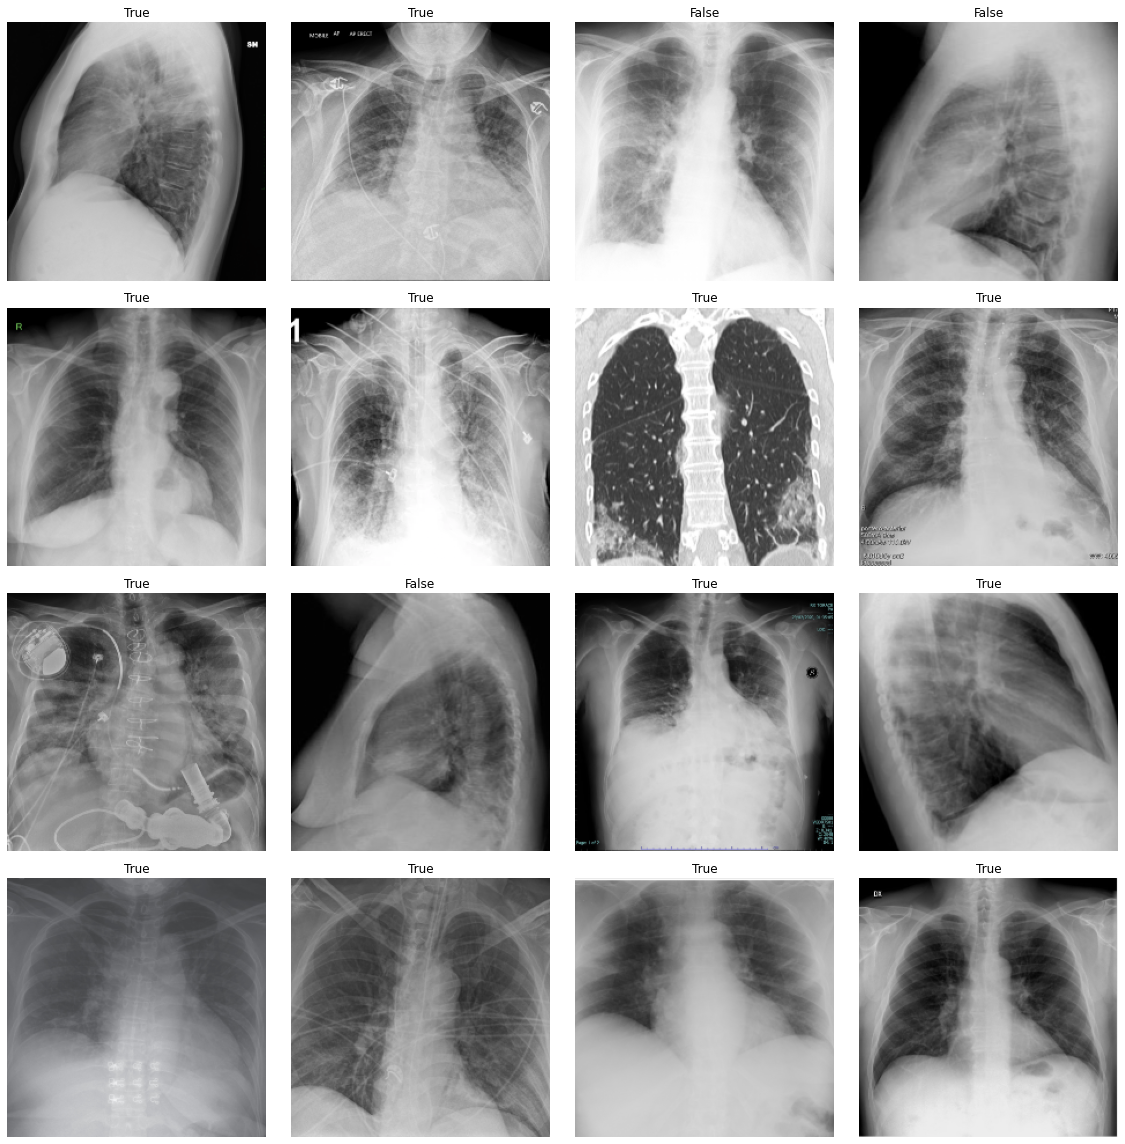

In [5]:
dataBunch.show_batch()

In [25]:
dataBunch.classes, dataBunch.c
#loaders = dataBunch.dl
#loader
#for batch_ndx, sample in enumerate(loader):

DeviceDataLoader(dl=<torch.utils.data.dataloader.DataLoader object at 0x7f07576ebfd0>, device=device(type='cpu'), tfms=[functools.partial(<function _normalize_batch at 0x7f07576d3560>, mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]), do_x=True, do_y=False)], collate_fn=<function data_collate at 0x7f0758927710>)

In [7]:
# primitive classification
#learn = cnn_learner(dataBunch, models.resnet18, metrics=error_rate)

In [8]:
#learn.fit_one_cycle(4)

In [9]:
#interp = ClassificationInterpretation.from_learner(learn)
#interp.plot_confusion_matrix()

In [10]:
#learn.export()
#model = learn.model

In [15]:
# try k-NN approach
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from cv2 import imread, IMREAD_GRAYSCALE

In [16]:
def read_one_picture(path):
    pic = Image.open(DATA_ROOT / path).convert('L')
    pic.thumbnail((224, 224), Image.ANTIALIAS)
    return np.asarray(pic)
df['pics'] = df['path'].map(read_one_picture)

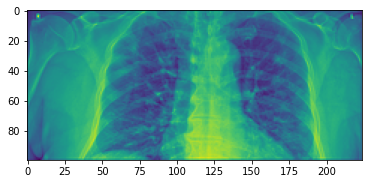

In [17]:
#for im in df.pics:
#    print(im.shape[0])
plt.imshow(df.pics[20])

In [ ]:
# TODO : split to vertical and horizontal images

from fastai_autoencoder.bottleneck import VAEBottleneck
from fastai_autoencoder.callback import VAEHook
from fastai_autoencoder.util import *
from fastai_autoencoder.vision.learn import VisionAELearner

train_size = 512
train_size = int(train_size * 1.25)
bs = 128
size = 28

data, valid_data = get_data(train_size,bs=bs,size=size)

# Architectural parameters of our model
conv = nn.Conv2d
act_fn = nn.ReLU
bn = nn.BatchNorm2d
rec_loss = "mse"

# Encoder architecture
enc_fn = create_encoder_denseblock
enc_args = {
    "n_dense":3,
    "c_start" :4
}

# Bottleneck architecture
bn_fn = VAEBottleneck
bn_args = {
    "nfs":[128,14]
}

# Decoder architecture
dec_fn = create_decoder
dec_args = {
    "nfs":[14,64,32,16,8,4,2,1],
    "ks":[3,1,3,1,3,1],   
    "size": 28
}

# We create each part of the autoencoder
enc = enc_fn(**enc_args)
bn = bn_fn(**bn_args)
dec = dec_fn(**dec_args)

# We wrap the whole thing in a learner, and add a hook for the KL loss
learn = VisionAELearner(data,rec_loss,enc,bn,dec)
kl_hook = VAEHook(learn,beta=1)

# We add this code to plot the reconstructions
dec_modules = list(learn.dec[1].children())
learn.set_dec_modules(dec_modules)